### Japaneese Candlestcks for a price trend prediction

In the previous part we used Linear Regression to predict the Close price. It was an univariate regression
since the Open price was a single feature. In this part, we are going to use Open, Close, High, and Low prices but
not directly as features but as a base for candlestcks formation which later on will be used for a classification
problem. If we plot the Close price as a line it provides us with a little information about behaviour/sentiment of the traiders.
In contrast, the candlestick chart displays a lot of addition information that may help to forecast the trend of the price. The candlestick charts are prefered way to analyse any type of instruments (stock market, Forex, cryptocurency, etc). Go to https://en.wikipedia.org/wiki/Candlestick_chart for more reading.

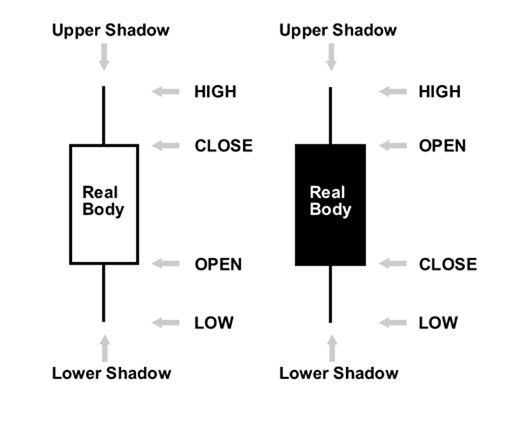

In [1]:
from IPython.display import Image
Image("http://s3.amazonaws.com/babypips-media-production/images/2016/05/grade2-candlestick.png")

Trading based on candlestick charts is a whole science itself. It was noticed that if a specific candlestick 
pattern was formed it gives a clue about the next market direction with a high probability. For example, if the market is in
up-trend(bullish) and "HANGING MAN" pattern oppeared, there is a huge chance that the direction will be inverted - 
from up-trend to down-trend. For more reading about patterns: https://www.forexboat.com/best-forex-candlestick-patterns/?utm_content=educational&utm_campaign=2017-04-05&utm_source=email-sendgrid&utm_term=24059364&utm_medium=308690,
https://www.luckscout.com/the-language-of-japanese-candlesticks-the-only-real-time-indicators/. So, detecting candlestick 
patterns can significantly increase our chances in market trend direction. There are many trading software, both free and commercial, which include candlestick pattern recognition functionality but we are going to build a machine learning classifier by ourselves. 

### Machine learning for pattern recognition

There is a huge number of candlestick patterns but for demonstration we are going to detect a "HANGING MAN" candle.

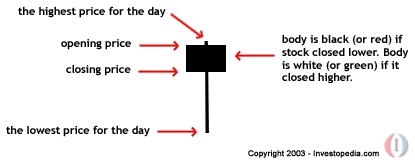

In [2]:
Image("http://i.investopedia.com/u53274/hanging_man_figure_1.jpg")

"HANGING MAN" candle is described as a candle with a very short upper shadow(sometimes there is no one), a long lower
shadow and a short body which is at least 2-3 times shorter than a lower shadow. 

One way to create a pattern recognition system is to use a rule-based approach where we provide a hardcoded parameters for the system. For instance, the body of the candle has to be 3 times less thah lower shadow. What if a candle's body is 2.95 times less than the lower shadow? In this case the system will fail to recognize a "HANGING MAN" candle because there is no rule which strictly defines all ratios. Another aproach is to 'show' to a machine learning algorithm a bunch of examples of "HANGING MAN" candles and a bunch of examples of non "HANGING MAN" candles and let it deside how to distinct(classify) them. 

In [3]:
# Importing libraries

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

Loading BokehJS ...

In [4]:
# Getting the stock price of Merck (pharmaceutical company)

merck = web.DataReader("MRK", "yahoo")

# To show a general candlestick chart(~ 1 month)
df = web.DataReader("MRK", "yahoo",'2013-02-02', '2013-03-02')

In [5]:
# Creating a candlestick chart with Bokeh library. Hover over any red candle to get a detailed info

C_O = (df['Close'] - df['Open']).values
colors = np.where(C_O > 0, 'green', 'red')

hover = HoverTool(
            tooltips="""
            <HEAD>
            <style>
            .bk-tooltip {
                background-color: #D3D3D3 !important;
                }
            </style>
            </HEAD>
            <HTML>
            <div style="background:#f7f8f9;">
                <div>
                    <span style="font-size: 14px;color:blue;">Open: </span>
                    <span style="font-size: 13px;">@O</span>
                </div>
                <div>
                    <span style="font-size: 14px;color:blue;">Close: </span>
                    <span style="font-size: 13px;">@C</span>
                </div>
                <div>
                    <span style="font-size: 14px;color:blue;">High: </span>
                    <span style="font-size: 13px;">@H</span>
                </div>
                <div>
                    <span style="font-size: 14px;color:blue;">Low: </span>
                    <span style="font-size: 13px;">@L</span>
                </div>
            </div>
            </HTML>
            """
)
tools = [hover, "box_zoom", 'pan', "wheel_zoom", 'undo', 'redo', "reset", 'resize']
source = ColumnDataSource(data=dict(O=df.Open.values,
                                    C=df.Close.values,
                                    H=df.High.values,
                                    L=df.Low.values,
                                    Date=df.index,
                                    Colors=colors))
w = 12*60*60*1000 # half day in ms
p = figure(tools=tools, plot_width=900, title="Merck stock prices for February 2013",
           plot_height=300, x_axis_type='datetime')
p.segment('Date', "H", "Date", "L", color="black", source=source)
p.vbar('Date', w, "O", 'C', fill_color = "Colors", line_color="black", source=source)
p.toolbar_location = 'above'
show(p)

We need to provide to ML algorithm some candlesticks. I manually selected 20 samples of "HANGING MAN" candles and 20
non "HANGING MAN" candles. This is a very small number of instances but for demostration purpuses it should work.

In [6]:
han_man = ['2010-01-08','2010-01-20','2010-01-27', '2010-02-05', '2010-02-24', '2010-02-25', '2010-03-12', '2012-08-02',
'2012-10-08', '2012-11-05', '2012-11-16', '2012-12-07', '2013-01-03', '2013-03-14', '2013-05-24', '2013-08-01',
'2013-10-29', '2013-12-30', '2013-12-04', '2014-08-15']

non_han_man = ['2014-08-08', '2014-08-22', '2014-08-21', '2014-08-20', '2014-09-15', '2014-09-25', '2014-09-29',
               '2014-09-30', '2014-10-01', '2016-01-13', '2016-01-14', '2016-01-27', '2016-01-29', '2016-02-04',
               '2016-02-09', '2016-02-10', '2016-02-11', '2016-03-01', '2016-03-04', '2016-03-22']

In [7]:
# Create a dataframe for hanning man samples

all_han_man = [merck.loc[i].values for i in han_man]
all_han_man = pd.DataFrame(all_han_man, columns=merck.columns)

In [8]:
all_han_man.head()

,Open,High,Low,Close,Volume,Adj Close
0,37.869999,37.889999,37.430000,37.700001,10767100.0,28.827006
1,40.639999,41.150002,39.970001,41.029999,20842700.0,31.373263
2,38.490002,38.779999,37.959999,38.639999,17483100.0,29.545769
3,37.049999,37.080002,35.820000,36.730000,22972300.0,28.085303
4,36.700001,37.040001,36.270000,36.930000,17093500.0,28.238232


In [9]:
# Create a dataframe for non hanning man samples

all_non_han_man = [merck.loc[i].values for i in non_han_man]
all_non_han_man = pd.DataFrame(all_non_han_man, columns=merck.columns)

In [10]:
all_non_han_man.head()

,Open,High,Low,Close,Volume,Adj Close
0,55.869999,56.610001,55.580002,56.549999,7081500.0,51.859120
1,59.040001,59.360001,58.900002,59.169998,5187600.0,54.261787
2,59.400002,59.660000,58.790001,58.849998,7646800.0,53.968332
3,58.680000,59.570000,58.529999,59.480000,7038400.0,54.546074
4,59.650002,59.990002,59.500000,59.520000,7738900.0,54.980908


#### Feature creation

All candles differ from each other by ratios of different parts to the height of the candle. For example, a ratio
of a body can be calculated using the following formula: abs(Close - Open)/(High - Low). Let's calculate the rest.

In [11]:
def get_body_ratio(df):
    return (df.Close - df.Open).abs()/(df.High - df.Low)

def get_upper_shadow_ratio(df):
    array = []
    for num, row in enumerate(df.iterrows()):
        open_, high, low, close, volume, adj_close =  row[1]
        if close > open_:
            array.append((high - close) / (high - low))
        elif high == close or high == open_ or close == open_:
            array.append(0.0001/(high - low))
        elif close < open_:
            array.append((high - open_)/(high - low))
    return np.array(array)
            
def get_lower_shadow_ratio(df):
    return 1 - get_body_ratio(df) - get_upper_shadow_ratio(df) 

In [12]:
# Creating a "hanning man" ratio dataframe

df_han_man = pd.DataFrame({'Body': get_body_ratio(all_han_man),
             'Upper': get_upper_shadow_ratio(all_han_man),
             'Lower': get_lower_shadow_ratio(all_han_man)})
df_han_man['Class'] = 1

In [13]:
df_han_man.head()

,Body,Lower,Upper,Class
0,0.369562,0.586960,0.043478,1
1,0.330508,0.567794,0.101697,1
2,0.182923,0.646345,0.170732,1
3,0.253967,0.722221,0.023812,1
4,0.298700,0.558442,0.142858,1


In [14]:
# Creating a non "hanning man" ratio dataframe

df_non_han_man = pd.DataFrame({'Body': get_body_ratio(all_non_han_man),
             'Upper': get_upper_shadow_ratio(all_non_han_man),
             'Lower': get_lower_shadow_ratio(all_non_han_man)})
df_non_han_man['Class'] = -1

In [15]:
df_non_han_man.head()

,Body,Lower,Upper,Class
0,0.660195,0.281551,0.058254,-1
1,0.282603,0.304346,0.413051,-1
2,0.632189,0.068962,0.298849,-1
3,0.769230,0.144232,0.086538,-1
4,0.265309,0.040816,0.693875,-1


In [16]:
X = pd.concat([df_han_man, df_non_han_man], ignore_index=True)[['Body', 'Lower', 'Upper']]
y = pd.concat([df_han_man, df_non_han_man], ignore_index=True)['Class']

In [17]:
X.shape, y.shape

((40, 3), (40,))

In [18]:
# Splitting the data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

Accuracy is: 1.0


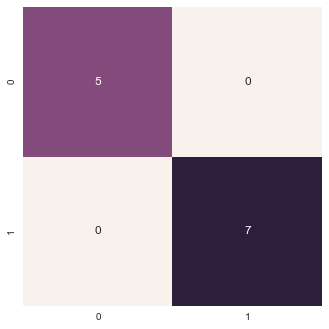

In [20]:
# Running a classifier

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_predict = log_reg.predict(X_test)
print("Accuracy is:", accuracy_score(y_test, log_reg_predict))
mat = confusion_matrix(y_test, log_reg_predict) 
sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.show()

In [21]:
# Creating a dataframe which contains Open, Close, High, Low prices for positively predicted 'hanning man' candles.
# We will use that dataframe to create a candle chart

predicted_df = pd.DataFrame({"Predicted": log_reg_predict}, index=y_test.index)

han_man_pred = pd.merge(predicted_df, pd.concat([all_han_man,all_non_han_man], ignore_index=True),
         left_index=True, right_index=True, how='inner')

han_man_pred = han_man_pred[han_man_pred["Predicted"] == 1]

In [22]:
# Making a simple candlestick chart with Bokeh.

def bk_candle(df, p):
    df_ = df.copy()
    df_["C-O"] = df_['Close'] - df_['Open']
    df_['Colors'] = df_['C-O'].apply(lambda x: "green" if x > 0 else "red")
    df_["Date"] = df_.index
    source = ColumnDataSource.from_df(df_)
    w = 0.25 # half day in ms
    p.segment('Date', "High", "Date", "Low", color="black", source=source)
    p.vbar('Date', w, "Open", 'Close', fill_color = "Colors", line_color="black", source=source)
    
p = figure(width=500, height=250)
bk_candle(han_man_pred, p)
show(p)

Our classifier did a great job at this point but we need to keep in mind that a small number of instances was used and
there is no strict rule that separates different types of candlesticks.

### Machine learning for a price trend prediction

In the section above we showed how to use machine learning for a "HANGING MAN" candle recognition. Since there are a lot of types
of candles it would be a very time consuming process to build a classifier for each of them. Instead, we will provide to a
classifier the ratios of all candlesticks. A very important thing to note is that a candlestick by itself provides
a liitle information about next direction of the trend. We need to take into account a previous candlestick since
it bears an information about the current trend. Also, a relative position of the previous candlestick plays a big
role too. Although a candlestick chart can be a poweful instrument to make a trend prediction, it is often used
along with some technical indicators to make a trading setup even more robust(more reading:
https://en.wikipedia.org/wiki/Technical_indicator, http://www.investopedia.com/terms/i/indicator.asp). We are also going to use some technical indicators for a trend prediction. So, we will include into features the following information:
    1. Ratios of the current candle
    2. Ratios of the previous candle
    3. Relative position of the previous candle
    4. Some technical indicators
    
**Goal**: predict the next day direction('UP' or 'DOWN')

We already know from the section above how to get ratios of different parts of the candlesticks. To get ratios of
the previous candle we just need to shift the dataframe.

In [23]:
# As in previous part we use AMAZON stock prices

df = web.DataReader("AMZN", "yahoo")

In [24]:
candle_df = pd.DataFrame({"body_ratio": get_body_ratio(df),
                           "upper_shadow_ratio": get_upper_shadow_ratio(df),
                           "lower_shadow_ratio": get_lower_shadow_ratio(df)})

In [25]:
candle_df.head()

,body_ratio,lower_shadow_ratio,upper_shadow_ratio
Date,,,
2010-01-04,0.677235,0.219019,0.103747
2010-01-05,0.343327,0.441416,0.215257
2010-01-06,0.762988,0.194807,0.042205
2010-01-07,0.571021,0.340908,0.088071
2010-01-08,0.636561,0.329032,0.034406


In [26]:
# Merging and shifting a dataframe to get current and previous candle ratios. Prefix 'p_' stands for previous.

merged_array = np.concatenate([candle_df.values[1:], candle_df.values[:-1]], axis=1)

merged_df = pd.DataFrame(merged_array, columns=['body_ratio', 'lower_shadow_ratio', 'upper_shadow_ratio', 'p_body_ratio',
       'p_lower_shadow_ratio', 'p_upper_shadow_ratio'], index = df.index[1:])

In [27]:
merged_df.head()

,body_ratio,lower_shadow_ratio,upper_shadow_ratio,p_body_ratio,p_lower_shadow_ratio,p_upper_shadow_ratio
Date,,,,,,
2010-01-05,0.343327,0.441416,0.215257,0.677235,0.219019,0.103747
2010-01-06,0.762988,0.194807,0.042205,0.343327,0.441416,0.215257
2010-01-07,0.571021,0.340908,0.088071,0.762988,0.194807,0.042205
2010-01-08,0.636561,0.329032,0.034406,0.571021,0.340908,0.088071
2010-01-11,0.643454,0.306405,0.050142,0.636561,0.329032,0.034406


In [28]:
# Calculating previous candle position by formulas: current_close - previous_close; current_open - previous_open

def get_candle_position(df):
    # Open price of current candlestick - Open price of previous candlestick
    delta_open = []
    # Close proce of current candlestick - Close price of previous candlestick
    delta_close = []
    for num, row in enumerate(df.iterrows()):
        if num == 0:
            continue
        else:
            open_p, high_p, low_p, close_p, volume_p, adj_close_p = df.ix[num - 1].values
            open_c, high_c, low_c, close_c, volume_c, adj_close_c = row[1].values
            delta_open.append(open_c - open_p) # 
            delta_close.append(close_c - close_p) # 
    return delta_open, delta_close

In [29]:
# Adding new feature into a dataframe

merged_df["O_c-O_p"] = get_candle_position(df)[0]
merged_df['C_c-C-p'] = get_candle_position(df)[1]

In [30]:
merged_df.head()

,body_ratio,lower_shadow_ratio,upper_shadow_ratio,p_body_ratio,p_lower_shadow_ratio,p_upper_shadow_ratio,O_c-O_p,C_c-C-p
Date,,,,,,,,
2010-01-05,0.343327,0.441416,0.215257,0.677235,0.219019,0.103747,-2.820007,0.790008
2010-01-06,0.762988,0.194807,0.042205,0.343327,0.441416,0.215257,1.170013,-2.440002
2010-01-07,0.571021,0.340908,0.088071,0.762988,0.194807,0.042205,-2.590011,-2.250000
2010-01-08,0.636561,0.329032,0.034406,0.571021,0.340908,0.088071,-1.449997,3.520004
2010-01-11,0.643454,0.306405,0.050142,0.636561,0.329032,0.034406,2.059997,-3.210006


It is time to add some technical indicators such as EMA, SMA, RSI, MACD, Bollinger Bands and differences
between Close/Open price and indicators. We used TA-LIB library for these calculations(https://mrjbq7.github.io/ta-lib/)

In [31]:
# Clculating indicators

df2 = df[1:]

merged_df['RSI_3'] = ta.RSI(df2['Close'].values, timeperiod=3)
merged_df['RSI_14'] = ta.RSI(df2['Close'].values, timeperiod=14)
merged_df["EMA_3"] = ta.EMA(df2.Close.values, timeperiod=3)
merged_df["EMA_10"] = ta.EMA(df2.Close.values, timeperiod=10)
merged_df["SMA_50"] = ta.SMA(df2.Close.values, timeperiod=50)

# MACD
macd_fast = df2.Close.ewm(span=12).mean().values
macd_slow = df2.Close.ewm(span=26).mean().values
macd_line = macd_fast - macd_slow

merged_df["MACD_Line"] = macd_line

# EMA and SMA
ema_3 = ta.EMA(df2.Close.values, timeperiod=3)
ema_10 = ta.EMA(df2.Close.values, timeperiod=10)
sma_50 = ta.SMA(df2.Close.values, timeperiod=50)

merged_df["EMA_3-EMA_10"] = ema_3 - ema_10
merged_df["EMA_10-SMA_50"] = ema_10 - sma_50

merged_df["C-EMA_3"] = df2.Close.values - ema_3
merged_df["C-EMA_10"] = df2.Close.values - ema_10
merged_df["C-SMA_50"] = df2.Close.values - sma_50

merged_df["O-EMA_3"] = df2.Open.values - ema_3
merged_df["O-EMA_10"] = df2.Open.values - ema_10
merged_df["O-SMA_50"] = df2.Open.values - sma_50

# Bollinger Bands

bb_up_2, bb_mid_2, bb_down_2 = ta.BBANDS(df2['Close'].values, timeperiod=20,nbdevdn=2, nbdevup=2)
bb_up_1, bb_mid_1, bb_down_1 = ta.BBANDS(df2['Close'].values, timeperiod=10,nbdevdn=1, nbdevup=1)

merged_df['C-bb_up_1'] = df2.Close.values - bb_up_1
merged_df['C-bb_mid_1'] = df2.Close.values - bb_mid_1
merged_df['C-bb_low_1'] = df2.Close.values - bb_down_1
merged_df['O-bb_up_1'] = df2.Open.values - bb_up_1
merged_df['O-bb_mid_1'] = df2.Open.values - bb_mid_1
merged_df['O-bb_low_1'] = df2.Open.values - bb_down_1

merged_df['C-bb_up_2'] = df2.Close.values - bb_up_2
merged_df['C-bb_mid_2'] = df2.Close.values - bb_mid_2
merged_df['C-bb_low_2'] = df2.Close.values - bb_down_2
merged_df['O-bb_up_2'] = df2.Open.values - bb_up_2
merged_df['O-bb_mid_2'] = df2.Open.values - bb_mid_2
merged_df['O-bb_low_2'] = df2.Open.values - bb_down_2

In [32]:
merged_df.head()

,body_ratio,lower_shadow_ratio,upper_shadow_ratio,p_body_ratio,p_lower_shadow_ratio,p_upper_shadow_ratio,O_c-O_p,C_c-C-p,RSI_3,RSI_14,...,C-bb_low_1,O-bb_up_1,O-bb_mid_1,O-bb_low_1,C-bb_up_2,C-bb_mid_2,C-bb_low_2,O-bb_up_2,O-bb_mid_2,O-bb_low_2
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.343327,0.441416,0.215257,0.677235,0.219019,0.103747,-2.820007,0.790008,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.762988,0.194807,0.042205,0.343327,0.441416,0.215257,1.170013,-2.440002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,0.571021,0.340908,0.088071,0.762988,0.194807,0.042205,-2.590011,-2.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.636561,0.329032,0.034406,0.571021,0.340908,0.088071,-1.449997,3.520004,42.874561,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,0.643454,0.306405,0.050142,0.636561,0.329032,0.034406,2.059997,-3.210006,27.024952,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Shifting dataframe to alighn with previous date. Also, converting price change into -1(price change < 0)
# and 1(price change > 0). Since we have SMA_50, we need to shift by 50 dates.

merged_df = merged_df[:-1]

merged_df["Price_change"] = df2.Close.diff().values[1:]

merged_df["Price_change"] = merged_df["Price_change"].apply(lambda x: 1 if x > 0 else -1)

merged_df = merged_df[49:]

In [34]:
merged_df.head()

,body_ratio,lower_shadow_ratio,upper_shadow_ratio,p_body_ratio,p_lower_shadow_ratio,p_upper_shadow_ratio,O_c-O_p,C_c-C-p,RSI_3,RSI_14,...,O-bb_up_1,O-bb_mid_1,O-bb_low_1,C-bb_up_2,C-bb_mid_2,C-bb_low_2,O-bb_up_2,O-bb_mid_2,O-bb_low_2,Price_change
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-17,0.727896,0.081629,0.190475,0.307257,0.413412,0.279331,1.169999,-0.449997,51.673476,61.767699,...,0.234760,1.756003,3.277247,-5.719524,5.856496,17.432515,-4.649516,6.926504,18.502523,1
2010-03-18,0.721987,0.240664,0.037349,0.727896,0.081629,0.190475,-1.390000,1.419999,72.157516,64.362380,...,-1.515638,-0.056996,1.401645,-4.923818,6.542495,18.008808,-6.663809,4.802504,16.268817,-1
2010-03-19,0.829629,0.170346,0.000025,0.721987,0.240664,0.037349,2.690003,-2.409989,34.706685,57.259816,...,1.188943,2.489006,3.789070,-7.377133,3.491006,14.359144,-4.017132,6.851007,17.719145,1
2010-03-22,0.116381,0.672411,0.211209,0.829629,0.170346,0.000025,-3.510010,0.119995,37.143213,57.511230,...,-2.330517,-1.057004,0.216510,-7.186027,2.988001,13.162028,-7.456031,2.717997,12.892024,-1
2010-03-23,0.567947,0.414631,0.017423,0.116381,0.672411,0.211209,0.690002,-1.210006,23.742167,54.058021,...,-1.604654,-0.411000,0.782653,-7.862837,1.176995,10.216827,-6.232833,2.806999,11.846831,-1


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [36]:
# Splitting the data

ratio = 0.7
n_train = int(merged_df.shape[0] * ratio)
n_test = merged_df.shape[0] - n_train

X = merged_df[merged_df.columns[:-1]].values
y = merged_df[merged_df.columns[-1]].values

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

In [37]:
# Logistic regression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
print(accuracy_score(y_test, log_reg_pred))

0.480373831776


In [38]:
# Support Vector Machine Classifier

svc = SVC(kernel='rbf', C=0.01, gamma=100).fit(X_train, y_train)
test_score = svc.score(X_test, y_test) 
print('SVC test_score: {0:.3f}'.format(test_score))

SVC test_score: 0.544


In [39]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=50, random_state=4, n_jobs=-1)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(accuracy_score(y_test, rfc_pred))

0.472897196262


As you see, the accuracy is low when we try to predict direction for 445 days. Let's see what accuracy is for 3, 5, 7, 10, 15 days 

In [40]:
days = [3, 5, 7, 10, 15]

In [41]:
print("Logistic regression:")
print('====================')
for day in days:
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    log_reg_pred = log_reg.predict(X_test[:day])
    print(day, "days accuracy is:",accuracy_score(y_test[:day], log_reg_pred))
    print ('-------------------')

Logistic regression:
3 days accuracy is: 0.666666666667
-------------------
5 days accuracy is: 0.6
-------------------
7 days accuracy is: 0.714285714286
-------------------
10 days accuracy is: 0.7
-------------------
15 days accuracy is: 0.733333333333
-------------------


In [42]:
print("SVC:")
print('====================')
for day in days:
    svc = SVC(kernel='rbf', C=0.01, gamma=100)
    svc.fit(X_train, y_train)
    svc_pred = svc.predict(X_test[:day])
    print(day, "days accuracy is:",accuracy_score(y_test[:day], svc_pred))
    print ('--------------------')

SVC:
3 days accuracy is: 0.333333333333
--------------------
5 days accuracy is: 0.4
--------------------
7 days accuracy is: 0.285714285714
--------------------
10 days accuracy is: 0.3
--------------------
15 days accuracy is: 0.4
--------------------


In [43]:
print("RandomForestClassifier:")
print('====================')
for day in days:
    rfc = RandomForestClassifier(n_estimators=50, random_state=4, n_jobs=-1)
    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test[:day])
    print(day, "days accuracy is:",accuracy_score(y_test[:day], rfc_pred))
    print ('-------------------')

RandomForestClassifier:
3 days accuracy is: 0.666666666667
-------------------
5 days accuracy is: 0.6
-------------------
7 days accuracy is: 0.714285714286
-------------------
10 days accuracy is: 0.8
-------------------
15 days accuracy is: 0.8
-------------------


As you see, we got much better result for short periods. Logistic Regression and RandomForestClassifier showed 80% of accuracy for a 5-days period. SVC and RandomForestClassifier gave 71% of accuracy fo a 7-days period.

### Building a simple user interface

In this project I used the stock prices of Amazon but a user can use any other company. Also, three time periods(they are commented out in the cell below) will be tested to check the performance of the system. A user can choose some other time periods.

In [44]:
ticker = "AMZN"
start_date = "2016-01-04" #"2010-01-05", "2014-01-02", "2016-01-04"
end_date = "2017-01-03"   #"2015-01-02", "2016-01-04", "2017-01-03"
days = [3, 5, 7, 10, 15]
period = 16

In [45]:
def get_data(df):    
    
    def get_body_ratio(df):
        return (df.Close - df.Open).abs()/(df.High - df.Low)

    def get_upper_shadow_ratio(df):
        array = []
        for num, row in enumerate(df.iterrows()):
            open_, high, low, close, volume, adj_close =  row[1]
            if close > open_:
                array.append((high - close) / (high - low))
            elif high == close or high == open_ or close == open_:
                array.append(0.0001/(high - low))
            elif close < open_:
                array.append((high - open_)/(high - low))
        return np.array(array)

    def get_lower_shadow_ratio(df):
        return 1 - get_body_ratio(df) - get_upper_shadow_ratio(df) 
    
    candle_df = pd.DataFrame({"body_ratio": get_body_ratio(df),
                           "upper_shadow_ratio": get_upper_shadow_ratio(df),
                           "lower_shadow_ratio": get_lower_shadow_ratio(df)})
    
    merged_array = np.concatenate([candle_df.values[1:], candle_df.values[:-1]], axis=1)

    merged_df = pd.DataFrame(merged_array, columns=['body_ratio', 'lower_shadow_ratio',
                                                    'upper_shadow_ratio', 'p_body_ratio',
                                                    'p_lower_shadow_ratio', 'p_upper_shadow_ratio'],
                                                     index = df.index[1:])
    
    def get_candle_position(df):
        # Open price of current candlestick - Open price of previous candlestick
        delta_open = []
        # Close proce of current candlestick - Close price of previous candlestick
        delta_close = []
        for num, row in enumerate(df.iterrows()):
            if num == 0:
                continue
            else:
                open_p, high_p, low_p, close_p, volume_p, adj_close_p = df.ix[num - 1].values
                open_c, high_c, low_c, close_c, volume_c, adj_close_c = row[1].values
                delta_open.append(open_c - open_p) # 
                delta_close.append(close_c - close_p) # 
        return delta_open, delta_close
    
    merged_df["O_c-O_p"] = get_candle_position(df)[0]
    merged_df['C_c-C-p'] = get_candle_position(df)[1]
    
    df2 = df[1:]

    merged_df['RSI_3'] = ta.RSI(df2['Close'].values, timeperiod=3)
    merged_df['RSI_14'] = ta.RSI(df2['Close'].values, timeperiod=14)
    merged_df["EMA_3"] = ta.EMA(df2.Close.values, timeperiod=3)
    merged_df["EMA_10"] = ta.EMA(df2.Close.values, timeperiod=10)
    merged_df["SMA_50"] = ta.SMA(df2.Close.values, timeperiod=50)

    # MACD
    macd_fast = df2.Close.ewm(span=12).mean().values
    macd_slow = df2.Close.ewm(span=26).mean().values
    macd_line = macd_fast - macd_slow

    merged_df["MACD_Line"] = macd_line

    # EMA and SMA
    ema_3 = ta.EMA(df2.Close.values, timeperiod=3)
    ema_10 = ta.EMA(df2.Close.values, timeperiod=10)
    sma_50 = ta.SMA(df2.Close.values, timeperiod=50)

    merged_df["EMA_3-EMA_10"] = ema_3 - ema_10
    merged_df["EMA_10-SMA_50"] = ema_10 - sma_50

    merged_df["C-EMA_3"] = df2.Close.values - ema_3
    merged_df["C-EMA_10"] = df2.Close.values - ema_10
    merged_df["C-SMA_50"] = df2.Close.values - sma_50

    merged_df["O-EMA_3"] = df2.Open.values - ema_3
    merged_df["O-EMA_10"] = df2.Open.values - ema_10
    merged_df["O-SMA_50"] = df2.Open.values - sma_50

    # Bollinger Bands

    bb_up_2, bb_mid_2, bb_down_2 = ta.BBANDS(df2['Close'].values, timeperiod=20,nbdevdn=2, nbdevup=2)
    bb_up_1, bb_mid_1, bb_down_1 = ta.BBANDS(df2['Close'].values, timeperiod=10,nbdevdn=1, nbdevup=1)

    merged_df['C-bb_up_1'] = df2.Close.values - bb_up_1
    merged_df['C-bb_mid_1'] = df2.Close.values - bb_mid_1
    merged_df['C-bb_low_1'] = df2.Close.values - bb_down_1
    merged_df['O-bb_up_1'] = df2.Open.values - bb_up_1
    merged_df['O-bb_mid_1'] = df2.Open.values - bb_mid_1
    merged_df['O-bb_low_1'] = df2.Open.values - bb_down_1

    merged_df['C-bb_up_2'] = df2.Close.values - bb_up_2
    merged_df['C-bb_mid_2'] = df2.Close.values - bb_mid_2
    merged_df['C-bb_low_2'] = df2.Close.values - bb_down_2
    merged_df['O-bb_up_2'] = df2.Open.values - bb_up_2
    merged_df['O-bb_mid_2'] = df2.Open.values - bb_mid_2
    merged_df['O-bb_low_2'] = df2.Open.values - bb_down_2
    
    merged_df = merged_df[:-1]

    merged_df["Price_change"] = df2.Close.diff().values[1:]

    merged_df["Price_change"] = merged_df["Price_change"].apply(lambda x: 1 if x > 0 else -1)

    merged_df = merged_df[49:]

    X = merged_df[merged_df.columns[:-1]].values
    y = merged_df[merged_df.columns[-1]].values
    
    return X, y

In [46]:
df = web.DataReader(ticker, "yahoo", start_date, end_date)

def check_date():
    """Check if the date in """
    if start_date not in df.index:
        print("Start date was not found, please choose another date")
        return None
    elif end_date not in df.index:
        print("End date was not found, please choose another date")
        return None
    else:
        return True
if check_date():    
    start_index = df.index.get_loc(start_date)
    end_index = df.index.get_loc(end_date)
    features_start_index = start_index - 49
    custom_df = df.ix[features_start_index:end_index + period]

    X, y = get_data(df)
    
    X_train, X_test = X[:-period], X[-period:]
    y_train, y_test = y[:-period], y[-period:]
    
    print("Logistic regression:")
    print('====================')
    for day in days:
        log_reg = LogisticRegression()
        log_reg.fit(X_train, y_train)
        log_reg_pred = log_reg.predict(X_test[:day])
        print(day, "days accuracy is:",accuracy_score(y_test[:day], log_reg_pred))
        print ('-------------------')
        
    print("SVC:")
    print('====================')
    for day in days:
        svc = SVC(kernel='rbf', C=0.01, gamma=100)
        svc.fit(X_train, y_train)
        svc_pred = svc.predict(X_test[:day])
        print(day, "days accuracy is:",accuracy_score(y_test[:day], svc_pred))
        print ('--------------------')
        
    print("RandomForestClassifier:")
    print('====================')
    for day in days:
        rfc = RandomForestClassifier(n_estimators=50, random_state=4, n_jobs=-1)
        rfc.fit(X_train, y_train)
        rfc_pred = rfc.predict(X_test[:day])
        print(day, "days accuracy is:",accuracy_score(y_test[:day], rfc_pred))
        print ('-------------------')

Logistic regression:
3 days accuracy is: 0.333333333333
-------------------
5 days accuracy is: 0.4
-------------------
7 days accuracy is: 0.428571428571
-------------------
10 days accuracy is: 0.4
-------------------
15 days accuracy is: 0.466666666667
-------------------
SVC:
3 days accuracy is: 0.666666666667
--------------------
5 days accuracy is: 0.4
--------------------
7 days accuracy is: 0.428571428571
--------------------
10 days accuracy is: 0.4
--------------------
15 days accuracy is: 0.4
--------------------
RandomForestClassifier:
3 days accuracy is: 0.666666666667
-------------------
5 days accuracy is: 0.6
-------------------
7 days accuracy is: 0.571428571429
-------------------
10 days accuracy is: 0.5
-------------------
15 days accuracy is: 0.6
-------------------


<center>**Accuracy table for Trainig period 2010-2015**</center>

| Model	|3 days |5 days |7 days	|10 days| 15 days|
|-------|-------|-------|-------|-------|--------|
| LogReg| 0.66 	| 0.4 	| 0.57 	| 0.6  	| 0.66   |
| SVC  	| 0.33 	| 0.2  	| 0.28 	| 0.4  	| 0.46   |
| RFC  	| 0.66 	| 0.4  	| 0.42 	| 0.3  	| 0.4    |

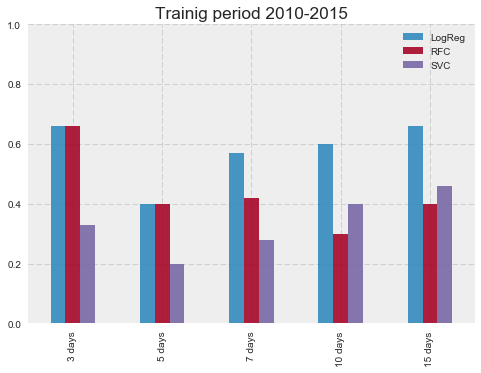

In [47]:
# Visualization for Trainig period 2010-2015

from collections import defaultdict

models_5 = defaultdict()
models_5["LogReg"] = [0.66, 0.4, 0.57, 0.6, 0.66]
models_5["SVC"] = [0.33, 0.2, 0.28, 0.4, 0.46]
models_5['RFC'] = [0.66, 0.4, 0.42, 0.3, 0.4]

models_5_df = pd.DataFrame(models_5, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
models_5_df.plot(kind='bar', ylim=(0, 1), alpha=0.9, title="Trainig period 2010-2015")
plt.savefig("/home/py-chemist/Desktop/models_5.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

<center>** Accuracy table for Trainig period 2014-2016**</center>

| Model	|3 days |5 days |7 days	|10 days| 15 days|
|-------|-------|-------|-------|-------|--------|
| LogReg| 0.66 	| 0.8 	| 0.85 	| 0.8  	| 0.6    |
| SVC  	| 0.33 	| 0.6  	| 0.42 	| 0.5  	| 0.46   |
| RFC  	| 0.0 	| 0.2  	| 0.42 	| 0.6  	| 0.66   |

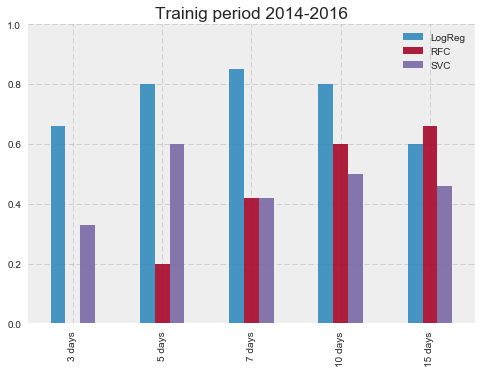

In [48]:
# Visualization for Trainig period 2014-2016

models_2 = defaultdict()
models_2["LogReg"] = [0.66, 0.8, 0.85, 0.8, 0.6]
models_2["SVC"] = [0.33, 0.6, 0.42, 0.5, 0.46]
models_2['RFC'] = [0.0, 0.2, 0.42, 0.6, 0.66]

models_2_df = pd.DataFrame(models_2, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
models_2_df.plot(kind='bar', ylim=(0, 1), alpha=0.9, title="Trainig period 2014-2016")
plt.show()

<center>**Accuracy table for Trainig period 2016-2017**</center>

| Model	|3 days |5 days |7 days	|10 days| 15 days|
|-------|-------|-------|-------|-------|--------|
| LogReg| 0.33 	| 0.4 	| 0.42 	| 0.4  	| 0.46   |
| SVC  	| 0.66 	| 0.4  	| 0.42 	| 0.4  	| 0.4    |
| RFC  	| 0.66 	| 0.6  	| 0.57 	| 0.5  	| 0.6    |

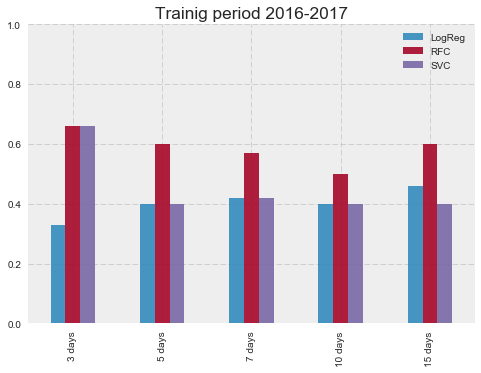

In [49]:
# Visualization for Trainig period 2016-2017

models_1 = defaultdict()
models_1["LogReg"] = [0.33, 0.4, 0.42, 0.4, 0.46]
models_1["SVC"] = [0.66, 0.4, 0.42, 0.4, 0.4]
models_1['RFC'] = [0.66, 0.6, 0.57, 0.5, 0.6]

models_1_df = pd.DataFrame(models_1, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
models_1_df.plot(kind='bar', ylim=(0, 1), alpha=0.9, title="Trainig period 2016-2017")
plt.savefig("/home/py-chemist/Desktop/models_1.png", dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Conclusion for this part

Trend prediction based on candlestck data and some technical indicators shows moderate results. Logistic regression overperformed other classifiers when training period is 5 and 2 years and has the lowest accuracy for a 1 year trainig period. Of course, there is a big room for improvements. For example, addition of other technical indicators may improve the accuracy. Another approach is to use PCA to reduce dimentinality hoping that not many feature are equally important for the model. Also, trying many others hyperparameters using gridsearch can lead to a better accuracy.

### Conclusions for the project

To come to a certain conclusion about the performance of both approaches, we need to compare the accuracy tables.
Since we tried 3 classifiers in the second part, we will choose the highest accuracy out of all three classifiers for the specific time period

<center>**Accuracy table for Trainig period 2010-2015**</center>

| Approach	 |3 days |5 days |7 days |10 days| 15 days|
|------------|-------|-------|-------|-------|--------|
| LinReg/Clsf| 0.66  | 0.6 	 | 0.57  | 0.5   | 0.46   |
| Clsf/combo | 0.66  | 0.4   | 0.57  | 0.6   | 0.66   |


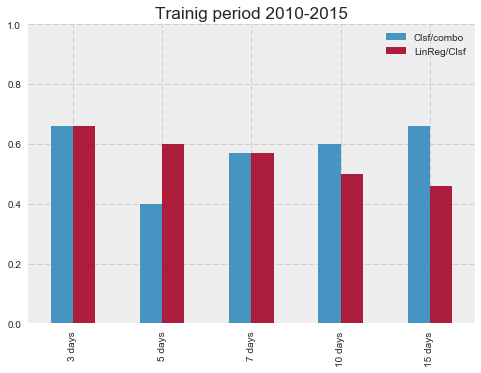

In [50]:
# Visualization for Trainig period 2010-2015

combo_5 = defaultdict()
combo_5["LinReg/Clsf"] = [0.66, 0.6, 0.57, 0.5, 0.46]
combo_5["Clsf/combo"] = [0.66, 0.4, 0.57, 0.6, 0.66]

combo_5_df = pd.DataFrame(combo_5, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
combo_5_df.plot(kind='bar', ylim=(0, 1), alpha=0.9, title="Trainig period 2010-2015")
plt.show()

<center>**Accuracy table for Trainig period 2014-2016**</center>


| Approach	 |3 days |5 days |7 days |10 days| 15 days|
|------------|-------|-------|-------|-------|--------|
| LinReg/Clsf| 1.0   | 0.8 	 | 0.85  | 0.8   | 0.86   |
| Clsf/combo | 0.66  | 0.8   | 0.85  | 0.8   | 0.6    |


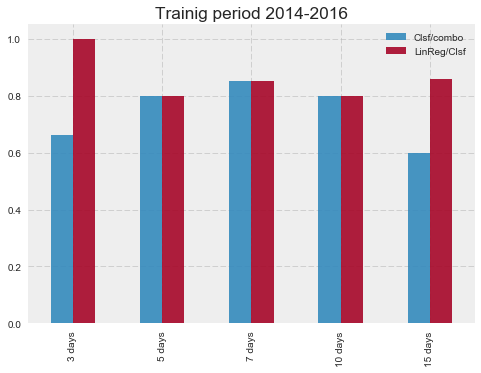

In [51]:
# Visualization for Trainig period 2014-2016

combo_2 = defaultdict()
combo_2["LinReg/Clsf"] = [1.0, 0.8, 0.85, 0.8, 0.86]
combo_2["Clsf/combo"] = [0.66, 0.8, 0.85, 0.8, 0.6]

combo_2_df = pd.DataFrame(combo_2, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
combo_2_df.plot(kind='bar', ylim=(0, 1.05), alpha=0.9, title="Trainig period 2014-2016")
plt.show()

<center>**Accuracy table for Trainig period 2016-2017**</center>


| Approach	 |3 days |5 days |7 days |10 days| 15 days|
|------------|-------|-------|-------|-------|--------|
| LinReg/Clsf| 1.0   | 1.0 	 | 0.85  | 0.8   | 0.73   |
| Clsf/combo | 0.66  | 0.6   | 0.57  | 0.5   | 0.6    |


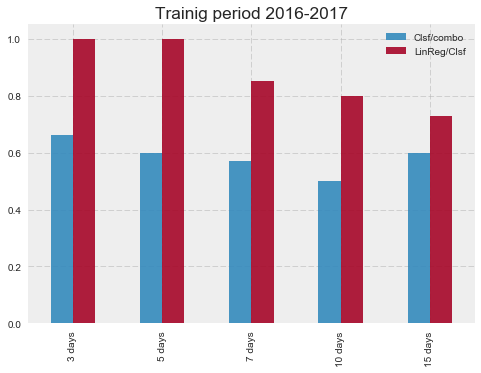

In [52]:
# # Visualization for Trainig period 2016-2017
combo_1 = defaultdict()
combo_1["LinReg/Clsf"] = [1.0, 1.0, 0.85, 0.8, 0.73]
combo_1["Clsf/combo"] = [0.66, 0.6, 0.57, 0.5, 0.6]

combo_1_df = pd.DataFrame(combo_1, index=['3 days', "5 days", '7 days', "10 days", "15 days"])
combo_1_df.plot(kind='bar', ylim=(0, 1.05), alpha=0.9, title="Trainig period 2016-2017")
plt.show()

Results form the tables shows that for the period of 5 years, the team of classifiers gives a little higher accuracy for 10 and 15-day periods but for a 5-days period the accuracy is lower in comparison to linear regression/classification method.

For a 2 year period, both methods have identical accuracy score for 5,7,10-days periods but for 3 and 15-day periods, method 1 performed much better.
Data from a 1-year period clearly shows that method 1 significantly outperformed the trio of classifiers.
Putting all together, we can conclude that the first approach in which we used linear regression to predict the Close price followed by classification task gives better results(accuracy score) than a combination of three classifiers which used technical indicators to predict the price trend. Analysis was done on stock prices of Amazon company with three training periods(1, 2, and 5 years). 